In [2]:
from pathlib import Path
import numpy as np 
from PIL import Image

import tensorflow.keras as keras

import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

2024-11-05 15:00:08.303201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
CLASSES = ['Healthy', 'OC Degeneration']
input_stages = {'0': 'training', '1': 'validation_nodiag', '2': 'validation_noxai'}
BASEPATH = Path('/Users/djohnson/sciebo/1. Research/1. HCXAI/1. Projects/evalxai_studies/example_validation_study')

In [4]:
def get_id(res_file: Path):
    return res_file.stem.split('_')[-1]

# ids from final stage to ensure completion
ids = [get_id(f) for f in (BASEPATH / 'validation_noxai/results').rglob('*.csv') if 'dj' not in get_id(f)]
ids.remove('f1021')
ids

['22793', '43787', '88888', '12345', 'bacha', '1254f', 'fm000', 'ED123']

In [5]:
dfs_1 = {id: pd.read_csv(BASEPATH / input_stages['1'] / 'results' / f'results_{input_stages["1"]}_{id}.csv') for id in ids}
dfs_2 = {id: pd.read_csv(BASEPATH / input_stages['2'] / 'results' / f'results_{input_stages["2"]}_{id}.csv') for id in ids}

In [6]:
def get_results(df, stage):
    acc = (df['true'] == df['select']).astype(int).mean()

    # stage one only has an accuracy value sine there is no AI
    if stage == '1':
       return acc
    
    agree_cond = df['pred'] == df['select']
    disagree_cond = df['pred'] != df['select']

    correct_preds = (df['pred'] == df['true'])
    incorrect_preds = (df['pred'] != df['true'])  

    # overreliance
    or_cond = agree_cond & incorrect_preds
    overreliance = (or_cond).astype(int).sum() / incorrect_preds.astype(int).sum()

    ur_cond = disagree_cond & correct_preds
    underreliance = (ur_cond).astype(int).sum() / correct_preds.astype(int).sum()

    # agreement
    reliance = (agree_cond).astype(int).sum() / len(df)
    
    # disagreement
    disagree = (disagree_cond).astype(int).sum() / len(df)

    # healthy distrust (prev. approp. reliance)
    hdt_cond = disagree_cond & incorrect_preds
    h_distrust = (hdt_cond).astype(int).sum() / (disagree_cond).astype(int).sum()

    # health trust
    ht_cond = agree_cond & correct_preds
    h_trust = (ht_cond).astype(int).sum() / (agree_cond).astype(int).sum()

    return acc, reliance, overreliance, underreliance, disagree, h_distrust, h_trust


In [7]:
# columns = ['id', 'accuracy1', 'accuracy2', 'reliance2', 'overreliance2', 'disagreement2', 'appropriate_reliance2']
dfs = []
for (id1, df1), (id2, df2) in zip(dfs_1.items(), dfs_2.items()):
    assert id1 == id2, 'IDs do not match'

    acc1 = get_results(df1, stage='1')
    acc2, reliance2, overreliance2, underreliance2, disagree2, h_distrust2, h_trust2 = get_results(df2, stage='2')

    results = dict(
        id = id1,
        accuracy1 = acc1, 
        accuracy2 = acc2, 
        reliance2 = reliance2,
        overreliance2 = overreliance2,
        underreliance2 = underreliance2,
        healthy_distrust2 = h_distrust2,
        healthy_trust2 = h_trust2
    )

    dfs.append(pd.DataFrame([results]))

df = pd.concat(dfs, ignore_index=True)
df.set_index('id', inplace=True)
df

,accuracy1,accuracy2,reliance2,overreliance2,underreliance2,healthy_distrust2,healthy_trust2
id,,,,,,,
22793,0.761905,0.738095,0.738095,0.500000,0.142857,0.636364,0.774194
43787,0.642857,0.666667,0.714286,0.571429,0.214286,0.500000,0.733333
88888,0.761905,0.809524,0.809524,0.500000,0.035714,0.875000,0.794118
12345,0.642857,0.666667,0.619048,0.428571,0.285714,0.500000,0.769231
bacha,0.761905,0.690476,0.738095,0.571429,0.178571,0.545455,0.741935
1254f,0.738095,0.785714,0.595238,0.214286,0.214286,0.647059,0.880000
fm000,0.738095,0.642857,0.738095,0.642857,0.214286,0.454545,0.709677
ED123,0.809524,0.690476,0.642857,0.428571,0.250000,0.533333,0.777778


In [8]:
df.describe()

,accuracy1,accuracy2,reliance2,overreliance2,underreliance2,healthy_distrust2,healthy_trust2
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.732143,0.711310,0.699405,0.482143,0.191964,0.586469,0.772533
std,0.059353,0.060284,0.073040,0.130875,0.076211,0.134310,0.051381
min,0.642857,0.642857,0.595238,0.214286,0.035714,0.454545,0.709677
25%,0.714286,0.666667,0.636905,0.428571,0.169643,0.500000,0.739785
50%,0.750000,0.690476,0.726190,0.500000,0.214286,0.539394,0.771712
75%,0.761905,0.750000,0.738095,0.571429,0.223214,0.639037,0.781863
max,0.809524,0.809524,0.809524,0.642857,0.285714,0.875000,0.880000


In [9]:
medians = df.median()
medians

accuracy1            0.750000
accuracy2            0.690476
reliance2            0.726190
overreliance2        0.500000
underreliance2       0.214286
healthy_distrust2    0.539394
healthy_trust2       0.771712
dtype: float64

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_48318/1505865982.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


(-0.1, 1.1)

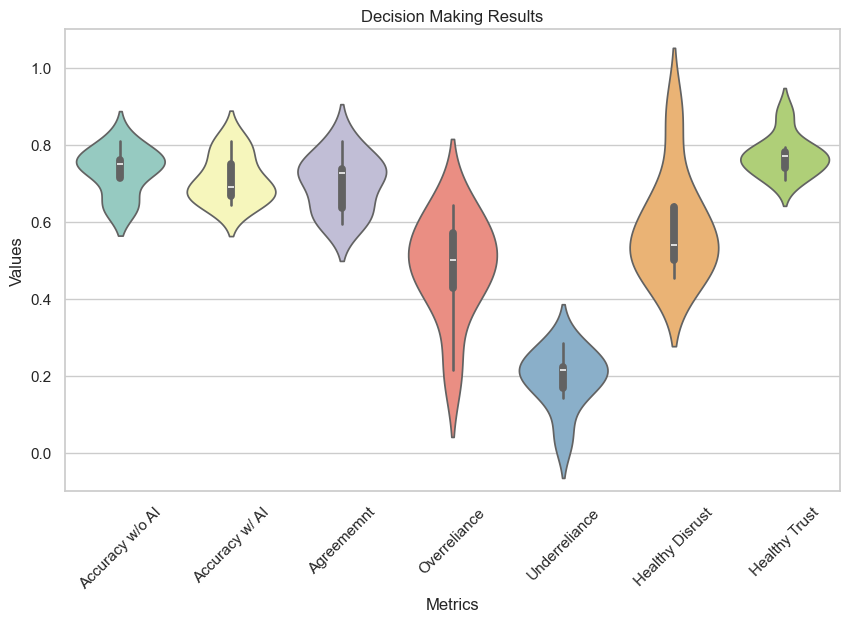

In [14]:
tick_labels = ['Accuracy w/o AI', 'Accuracy w/ AI', 'Agreememnt', 'Overreliance', 'Underreliance',  'Healthy Disrust', 'Healthy Trust']
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df, inner='box', palette='Set3')  # Set inner=None to remove bars

df_tmp = df[['accuracy1', 'accuracy2']]
# for index, row in df_tmp.iterrows():
#   plt.plot(df_tmp.columns, row, marker='o', label=f'ID {index}')

plt.title('Decision Making Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
ax.set_xticklabels(tick_labels)
plt.xticks(rotation = 45)

plt.ylim([-0.1, 1.1])
# plt.legend()

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_48318/1887224819.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


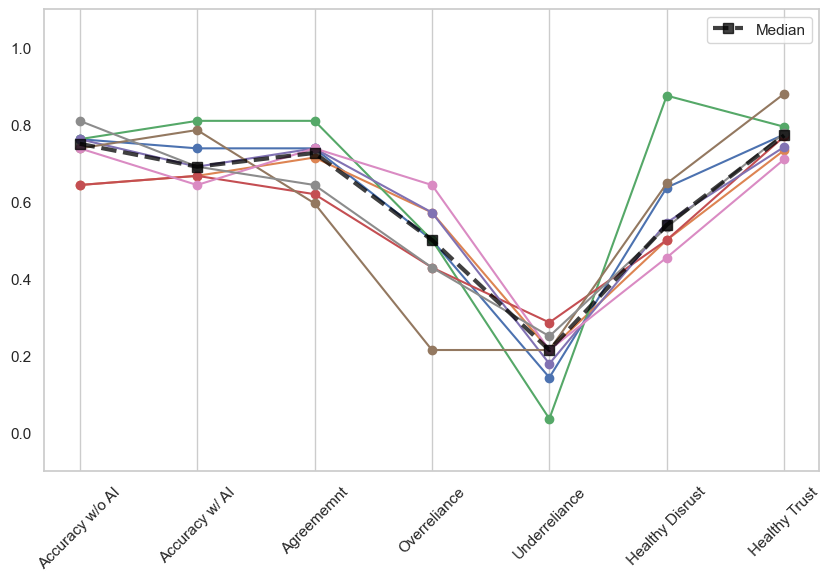

In [149]:
# Create a line plot for each row
plt.figure(figsize=(10, 6))  # Set the figure size


# Plot each row's values as a separate line
for index, row in df.iterrows():
  plt.plot(df.columns, row, marker='o')

plt.plot(df.columns, medians, marker='s', label=f'Median', linestyle='--', linewidth=3, color='black', alpha=0.75, markersize=7)

ax = plt.gca()
ax.set_xticklabels(tick_labels)
plt.xticks(rotation = 45)
ax.grid(False, axis='y')

plt.ylim([-0.1, 1.1])
plt.legend()

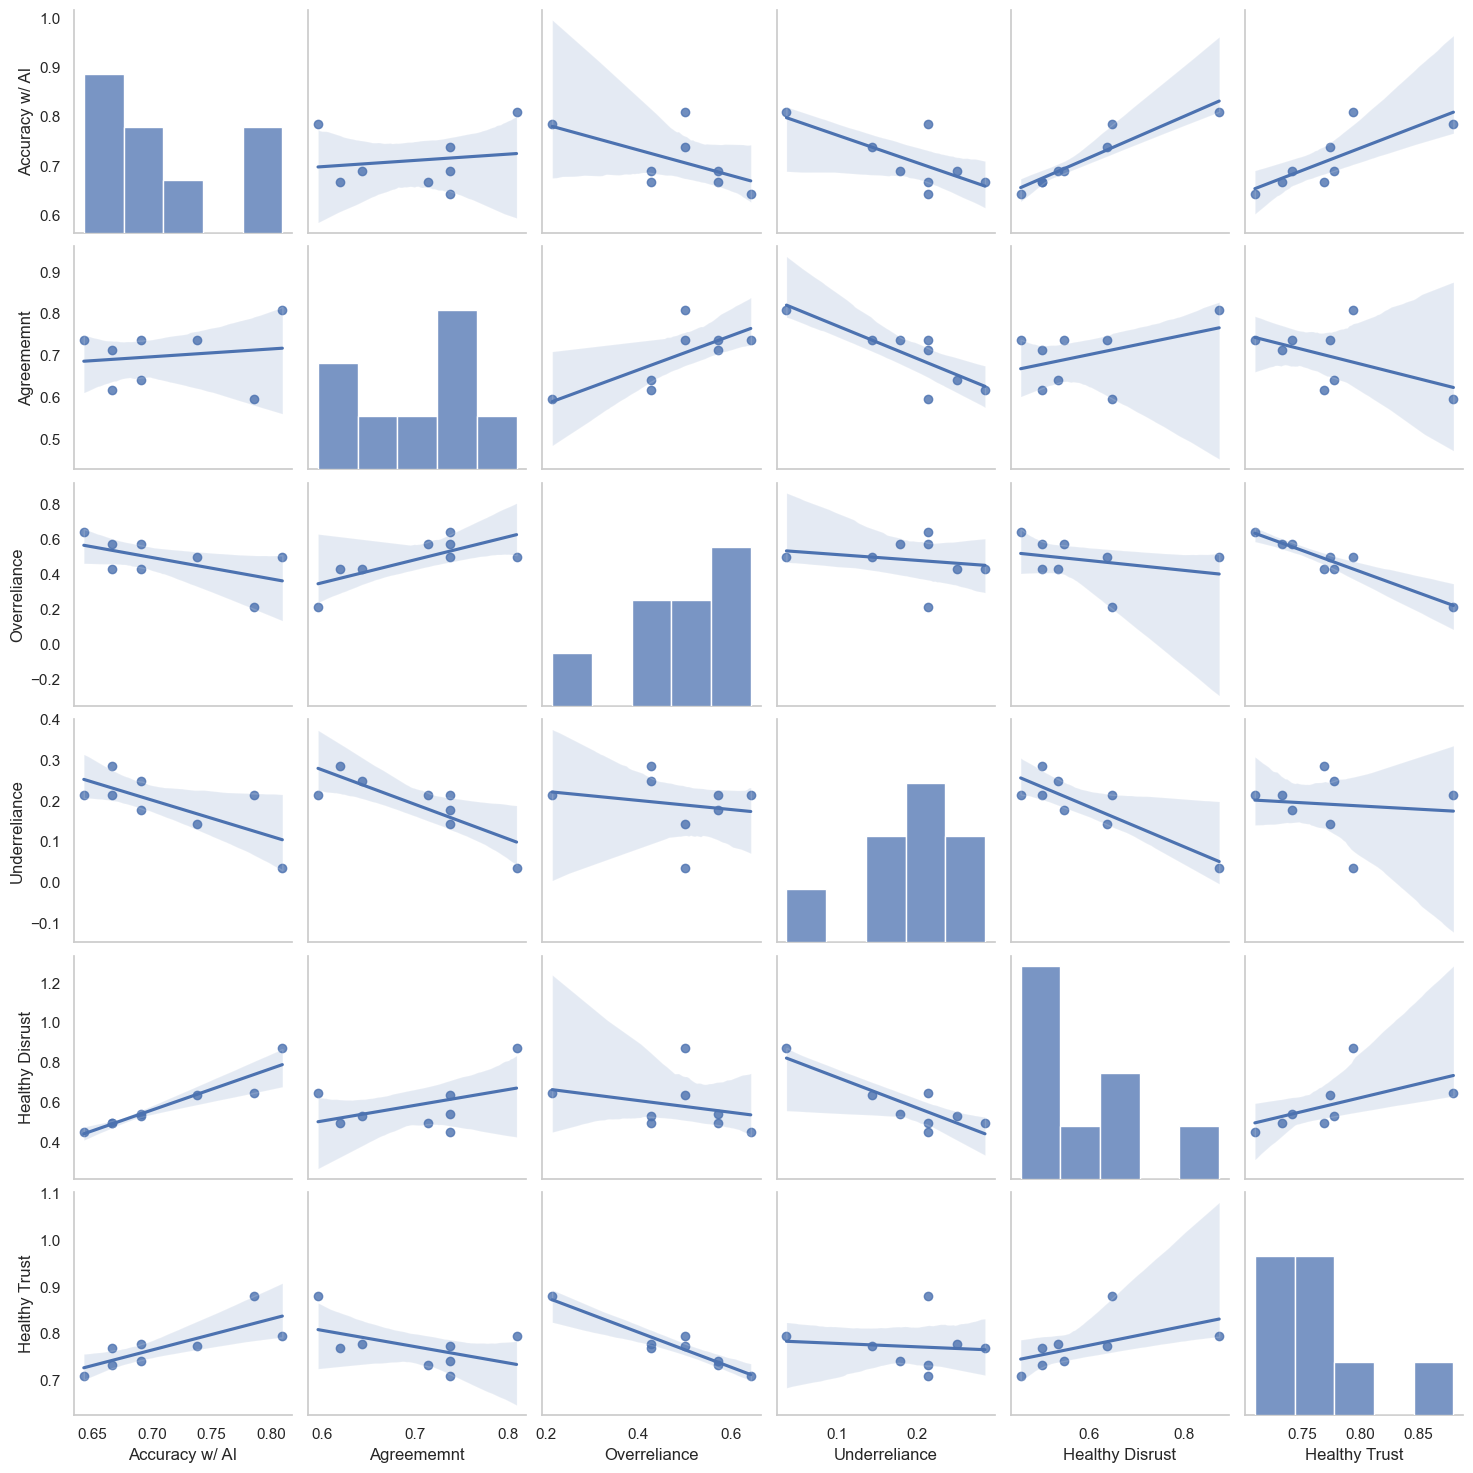

In [16]:
labels = tick_labels[1:]
df_tmp = df.drop(columns=['accuracy1'])
axes = sns.pairplot(df_tmp, kind='reg', diag_kind='hist', diag_kws={'bins': 5})
# Disable grid for each axis in the pair plot
for ax in axes.axes.flat:
    ax.grid(False)

for i, ax_row in enumerate(axes.axes):
  for j, ax in enumerate(ax_row):
    if j == 0:
      ax.set_ylabel(labels[i])
    if i == len(axes.axes) - 1:
      ax.set_xlabel(labels[j])


In [17]:
df.describe()

,accuracy1,accuracy2,reliance2,overreliance2,underreliance2,healthy_distrust2,healthy_trust2
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.732143,0.711310,0.699405,0.482143,0.191964,0.586469,0.772533
std,0.059353,0.060284,0.073040,0.130875,0.076211,0.134310,0.051381
min,0.642857,0.642857,0.595238,0.214286,0.035714,0.454545,0.709677
25%,0.714286,0.666667,0.636905,0.428571,0.169643,0.500000,0.739785
50%,0.750000,0.690476,0.726190,0.500000,0.214286,0.539394,0.771712
75%,0.761905,0.750000,0.738095,0.571429,0.223214,0.639037,0.781863
max,0.809524,0.809524,0.809524,0.642857,0.285714,0.875000,0.880000


In [43]:
for id1, df1 in dfs_1.items():
    df1['userid'] = id1

for id2, df2 in dfs_2.items():
    df2['userid'] = id2

df_noai = pd.concat(dfs_1.values())
df_ai = pd.concat(dfs_2.values())

In [44]:
df_noai

,id,true,pred,select,userid
0,c8a777a2-4067-406e-a1ec-d93de720c4bc,0,0,0,22793
1,dcab2c2e-9f11-49fc-9250-345ccbfbe2a3,1,0,1,22793
2,bab2c129-8c7d-49bb-bb02-84c08581915a,0,0,0,22793
3,d4e215b5-8373-4118-bc64-8a2f7872655b,0,1,0,22793
4,4f383912-0ee6-4bc2-a82f-4be6f9514713,0,0,0,22793
...,...,...,...,...,...
37,e50b8d09-34d4-4e48-8cd6-fa796e4e873e,1,1,1,ED123
38,f0b1282c-5c95-48ae-93f8-73d80dc78244,0,0,0,ED123
39,357d18e9-52a7-4c39-aab6-9fe6cedd0571,0,0,0,ED123
40,768159d9-8da4-4004-8ca5-b40a0969ae53,0,0,0,ED123


In [24]:
df_ai

,id,true,pred,select,userid
0,357d18e9-52a7-4c39-aab6-9fe6cedd0571,0,0,0,22793
1,f0b1282c-5c95-48ae-93f8-73d80dc78244,0,0,0,22793
2,f2ad41b2-29f0-4dfb-ab6f-db947bafe2c2,0,1,1,22793
3,0035c5bb-5704-4a5a-9f53-dea0b9513ba6,1,0,0,22793
4,50ef96f0-13dc-40fd-864e-fb84ccb59e44,0,1,0,22793
...,...,...,...,...,...
37,067ddf35-4612-4d07-9339-215da1672f72,1,0,1,ED123
38,85268050-f38c-41a7-bf0a-1b94941a1ec5,1,1,0,ED123
39,ea501f43-ff31-47e4-939e-64a05101b8a5,1,1,1,ED123
40,89a1f820-9719-4085-aa1b-f058c3b3442e,1,1,0,ED123


In [25]:
get_results(df_ai, stage=2)

(0.7113095238095238,
 0.6994047619047619,
 0.48214285714285715,
 0.19196428571428573,
 0.3005952380952381,
 0.5742574257425742,
 0.7702127659574468)

In [26]:
agree_cond = df_ai['pred'] == df_ai['select']
disagree_cond = df_ai['pred'] != df_ai['select']

correct_preds = (df_ai['pred'] == df_ai['true'])
incorrect_preds = (df_ai['pred'] != df_ai['true'])

or_cond = incorrect_preds & agree_cond
ur_cond = correct_preds & disagree_cond

ht_cond = agree_cond & correct_preds
hd_cond = disagree_cond & incorrect_preds

ht_cond.astype(int).sum(), hd_cond.astype(int).sum(), or_cond.astype(int).sum(), ur_cond.astype(int).sum()

(181, 58, 54, 43)

In [137]:
df_or = df_ai[or_cond]['id'].value_counts().reset_index()
df_ur = df_ai[ur_cond]['id'].value_counts().reset_index()
df_hd = df_ai[hd_cond]['id'].value_counts().reset_index()
df_ht = df_ai[ht_cond]['id'].value_counts().reset_index()

In [29]:
gdrive = Path('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive')
samples_path = gdrive / 'hcxai' / 'blocky_diagnosis'


xai_samples_csv = samples_path / 'original_input' / ' nobias_model' / '2024-10-17' / f'xai_samples' / 'xai_samples_df.csv'
df_xai_samples = pd.read_csv(xai_samples_csv )

In [31]:
data_dir_sickones = keras.utils.get_file(
    origin = "file:///Users/djohnson/sciebo/1. Research/1. HCXAI/1. Projects/two4two_datasets/two4two_datasets.tar.gz",
    fname = 'two4two_datasets.tar.gz',
    extract = True,
    archive_format = 'tar', 
    # force_download = False
)
data_dir_sickones = Path(data_dir_sickones)

In [32]:
nobias_dir = data_dir_sickones.with_suffix('').with_suffix('') / 'sick_ones_bendbias'
nobias_dir

PosixPath('/Users/djohnson/.keras/datasets/two4two_datasets/sick_ones_bendbias')

In [33]:
def get_image(id):
  f_path = nobias_dir / 'test' / df_xai_samples.loc[df_xai_samples.id == id, 'filename'].values[0]
  image = np.array(Image.open(f_path).convert('RGB')) * 1. / 255
  return image

In [34]:
most_or_images = df_or[df_or['count'] > 4]
imgs = {s.id: get_image(s.id) for _, s in most_or_images.iterrows()}
len(imgs)

6

In [176]:
df_or

,id,count
0,2e646ea0-fde6-48be-b45d-36786ababfd4,8
1,0035c5bb-5704-4a5a-9f53-dea0b9513ba6,7
2,5aed3aae-857b-4fde-bd39-fa7a9a784b8e,7
3,0a171071-b821-4f37-8cfe-9fec6b34391a,6
4,03a5305d-4f64-4f9a-81da-d3da889cfd3c,5
5,067ddf35-4612-4d07-9339-215da1672f72,5
6,f2ad41b2-29f0-4dfb-ab6f-db947bafe2c2,4
7,7b9a7adf-d9b8-412e-8836-c269cd6df127,3
8,d4e215b5-8373-4118-bc64-8a2f7872655b,3
9,41002a17-0b92-4d5c-ad0e-dd6b195c397c,2


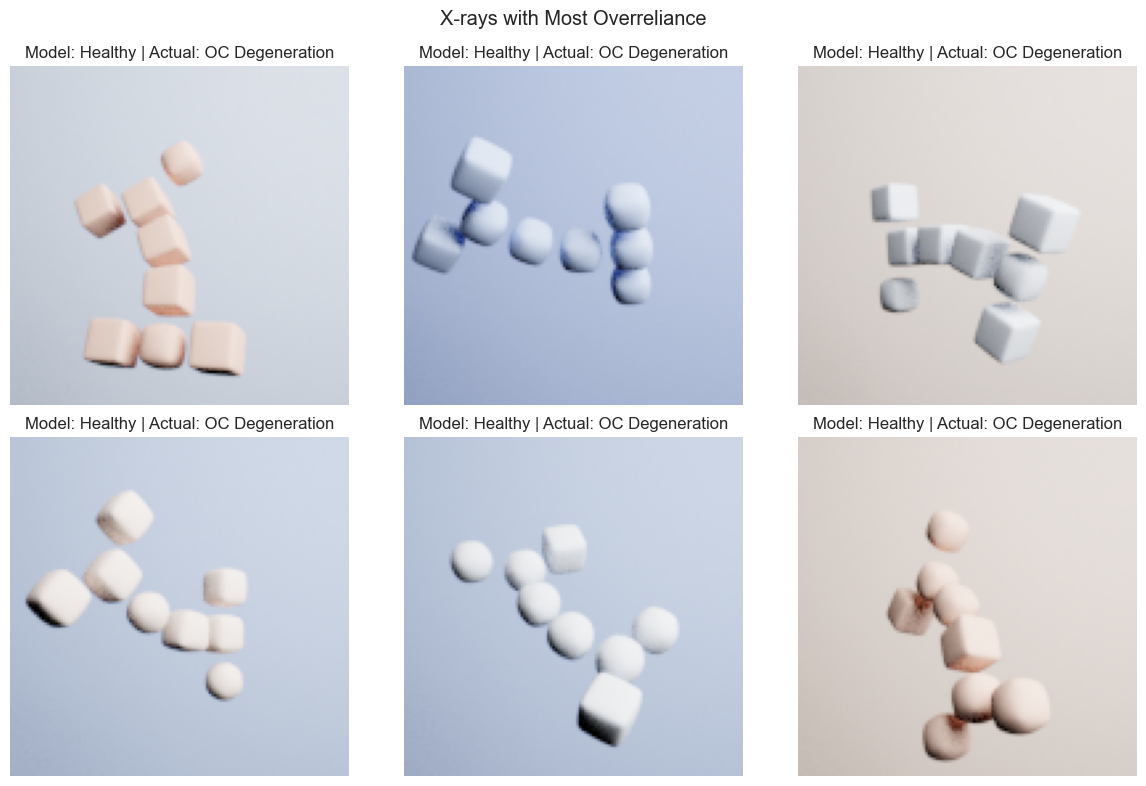

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'nobias_pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
plt.suptitle('X-rays with Most Overreliance')
plt.tight_layout()

In [36]:
most_ur_images = df_ur[df_ur['count'] > 2]
ur_imgs = {s.id: get_image(s.id) for _, s in most_ur_images.iterrows()}
len(ur_imgs)

7

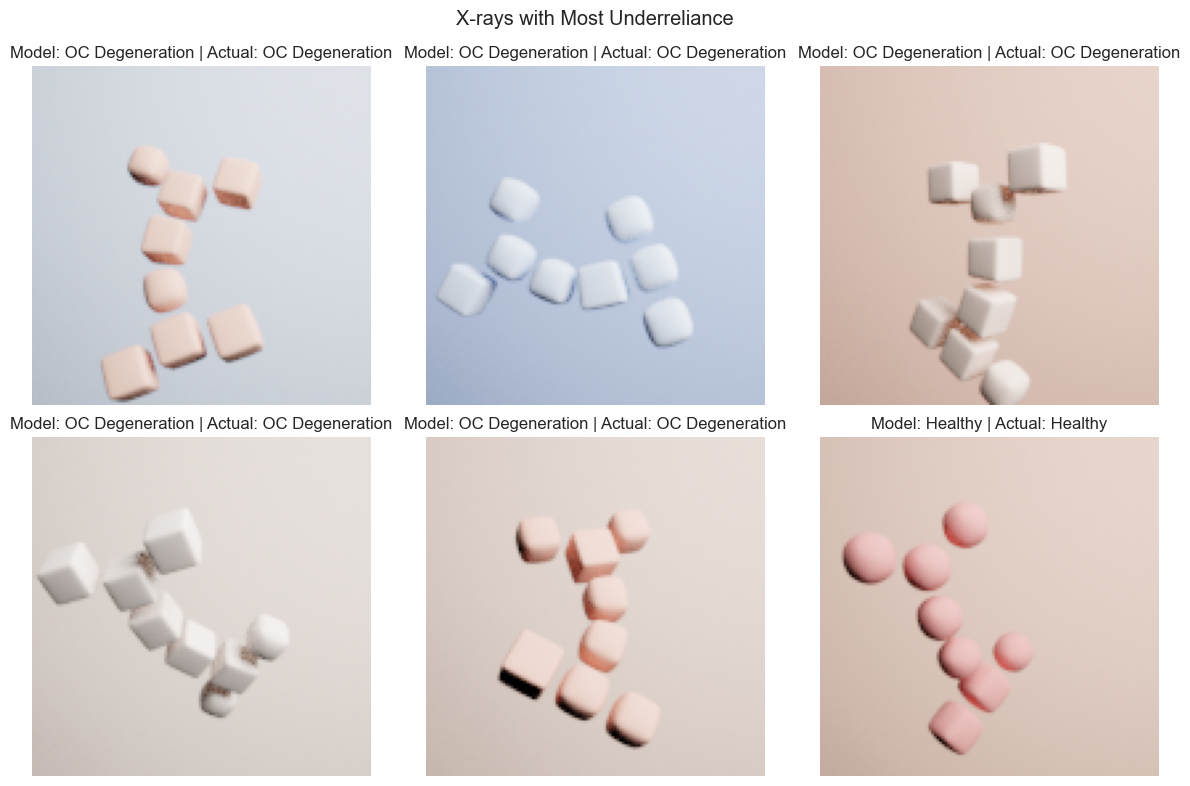

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), ur_imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'nobias_pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Underreliance')
plt.tight_layout()

In [38]:
most_hd_images = df_hd[df_hd['count'] > 2]
hd_imgs = {s.id: get_image(s.id) for _, s in most_hd_images.iterrows()}
len(hd_imgs)

10

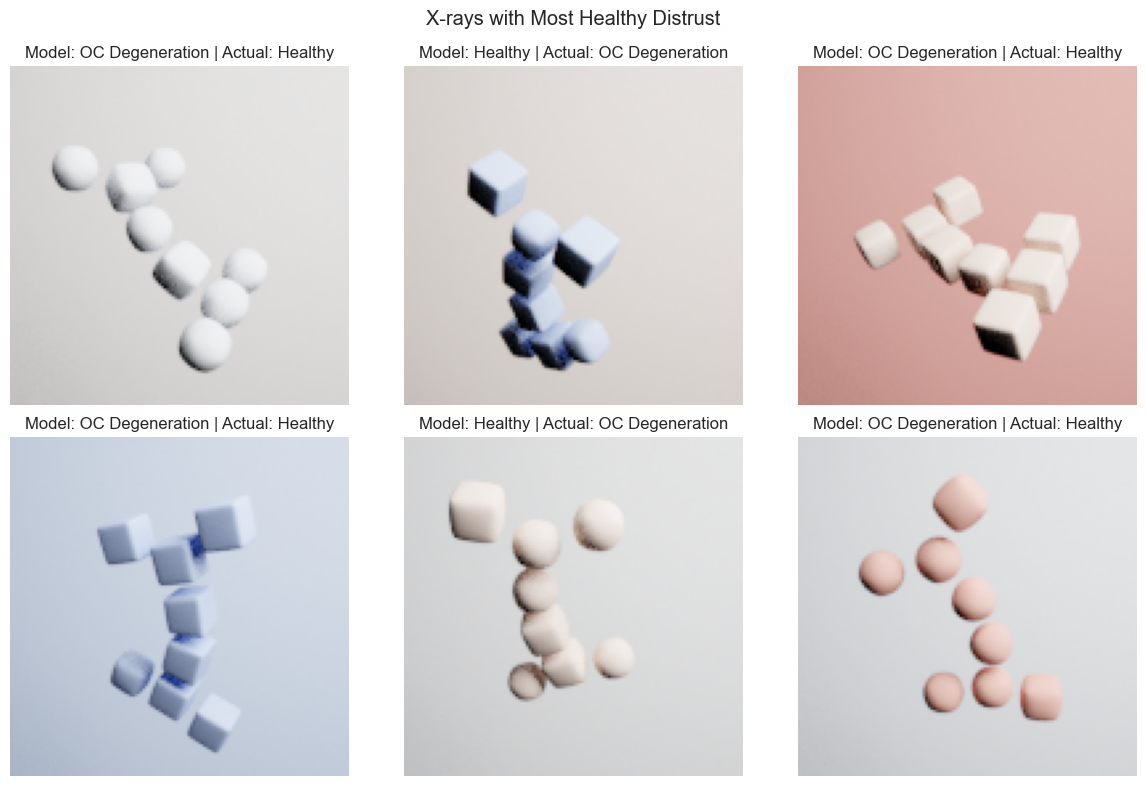

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), hd_imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'nobias_pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Healthy Distrust')
plt.tight_layout()

In [140]:
most_ht_images = df_ht[df_ht['count'] > 5]
ht_imgs = {s.id: get_image(s.id) for _, s in most_ht_images.iterrows()}
len(ht_imgs)

21

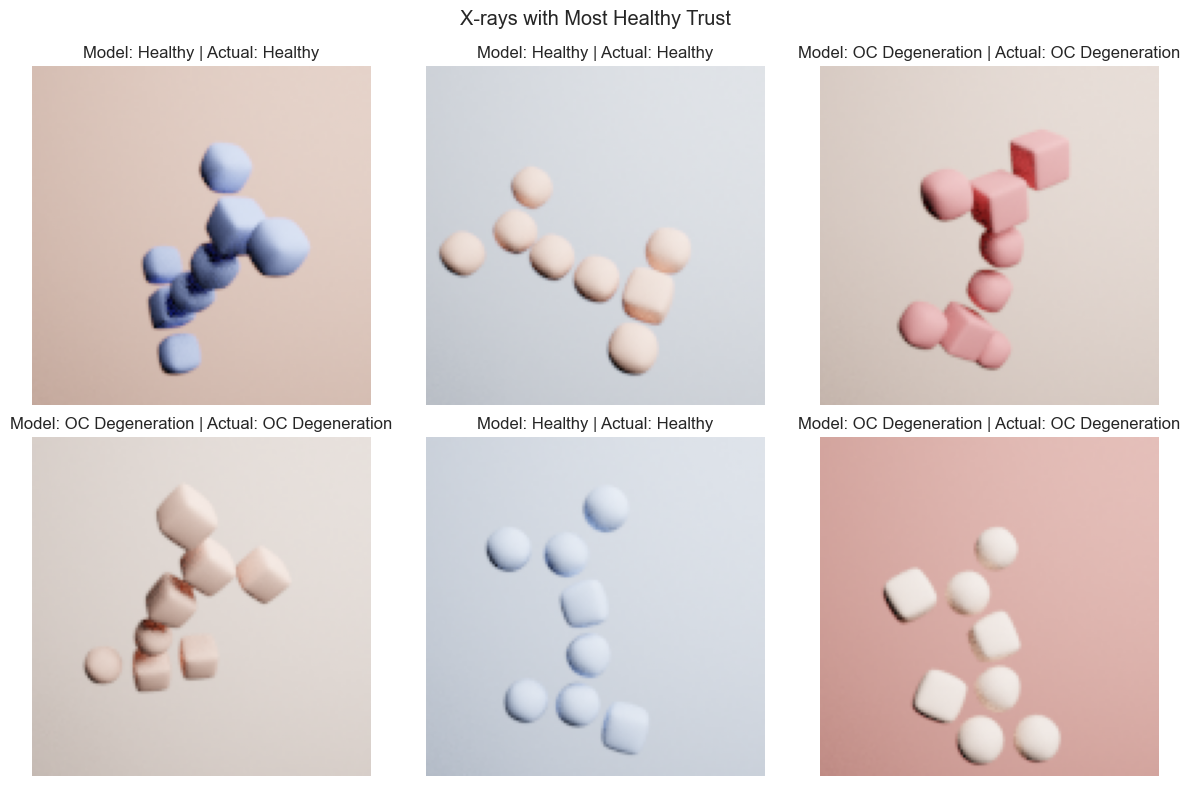

In [141]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), ht_imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'nobias_pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Healthy Trust')
plt.tight_layout()

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [169]:
def plot_cms(df_ai, df_noai, cond, name):

  ids, uids = df_ai[cond]['id'], df_ai[cond]['userid']
  rows = []
  for id, uid in zip(ids, uids):
    rows.append(df_noai[(df_noai['id']==id) & (df_noai['userid']==uid)])
  df_noai_cond = pd.concat(rows)

  cm_noai = confusion_matrix(df_noai_cond['true'], df_noai_cond['select'])
  cm_ai = confusion_matrix(df_ai[cond]['true'], df_ai[cond]['select'])

  maxlim = max(cm_noai.max(), cm_ai.max())

  fig, axes = plt.subplots(2, 1, figsize=(6, 10))

  disp = ConfusionMatrixDisplay(cm_noai, display_labels=CLASSES)
  disp.plot(cmap='Blues', ax = axes[0], colorbar=False)
  axes[0].grid(False)
  axes[0].set_title('User Diagnoses - No AI')
  axes[0].set_xticklabels([])
  axes[0].set_xlabel("")
  axes[0].set_yticklabels(CLASSES, rotation=90,  ha='right', va='center')
  im = axes[0].images[0]
  im.set_clim(0, maxlim) 

  disp = ConfusionMatrixDisplay(cm_ai, display_labels=CLASSES)
  disp.plot(cmap='Blues', ax = axes[1], colorbar=False)
  axes[1].grid(False)
  axes[1].set_yticklabels(CLASSES, rotation=90, ha='right', va='center')
  axes[1].set_title('User Diagnoses - With AI')
  im = axes[1].images[0]
  im.set_clim(0, maxlim) 

  plt.suptitle(f'User Diagnoses - {name}')
  plt.tight_layout()

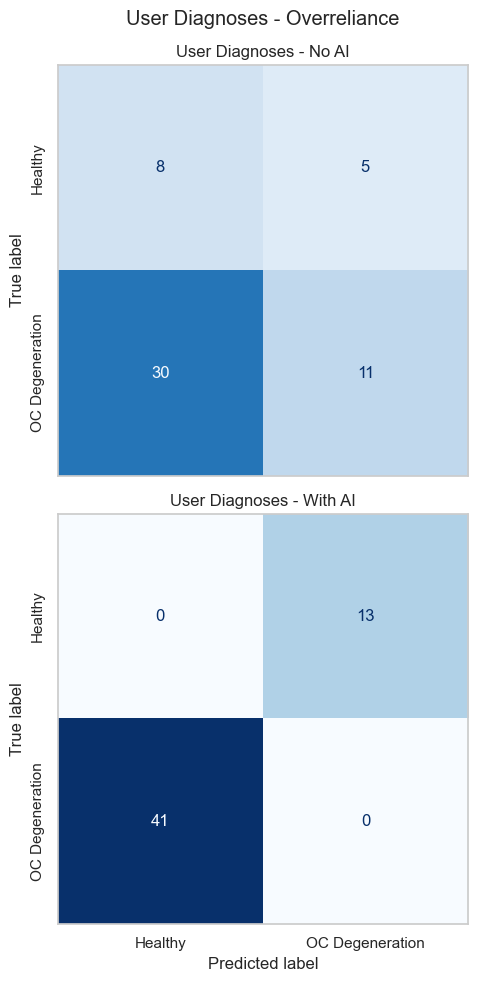

In [170]:
plot_cms(df_ai, df_noai, or_cond, 'Overreliance')

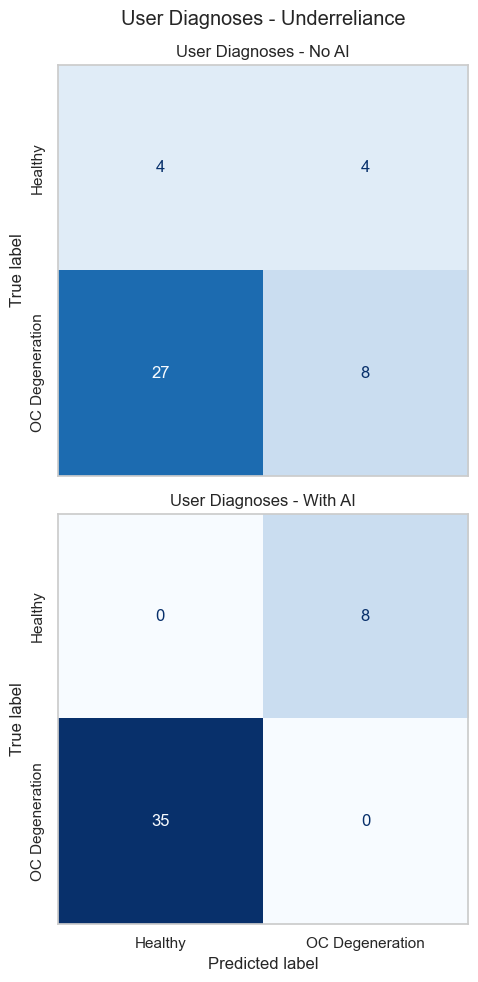

In [171]:
plot_cms(df_ai, df_noai, ur_cond, 'Underreliance')

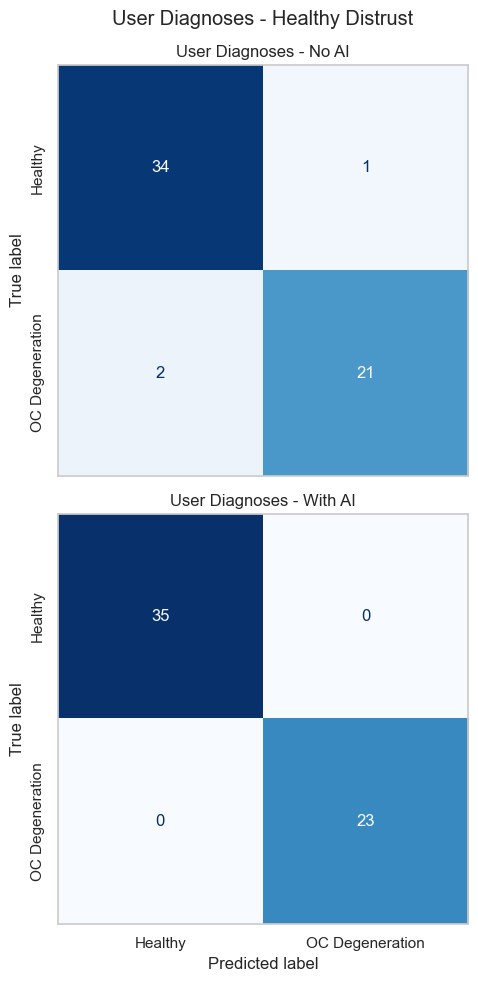

In [172]:
plot_cms(df_ai, df_noai, hd_cond, 'Healthy Distrust')

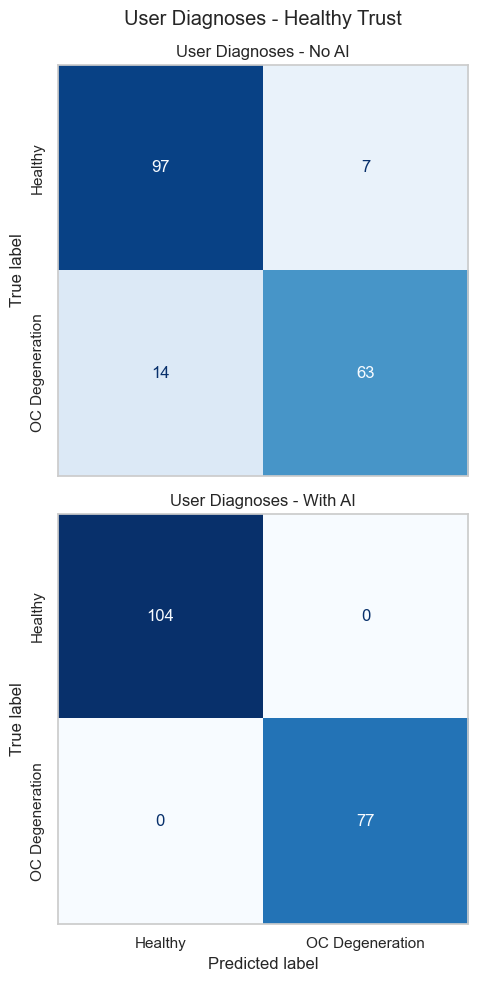

In [173]:
plot_cms(df_ai, df_noai, ht_cond, 'Healthy Trust')